In [1]:
import os

if "run_molecular_property_based_filtering.py" not in os.listdir():
    os.chdir("../src")

os.listdir()

['database',
 'utils',
 'screening',
 'run_molecular_property_based_filtering.py',
 '__init__.py']

---

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv(
    "../data/chembl_34_initial_screening_results.csv", sep=",", index_col=0
)

In [4]:
display(df.head())
df.shape

,Lipinski_Rule_of_5,Ghose_Filter,Veber_Filter,Rule_of_3_Filter,REOS_Filter,Drug_like_Filter,QED_Filter,TPSA_Filter,SA_Score_Filter,NP_Score_Filter,Errors
ChemblID,,,,,,,,,,,
CHEMBL153534,True,False,True,False,True,True,0.608781,82.22,3.048474,-1.552303,[]
CHEMBL440060,False,False,False,False,False,False,0.016357,1271.93,9.084590,-0.037746,[]
CHEMBL440245,False,False,False,False,False,False,0.010798,1502.95,9.752879,0.219818,[]
CHEMBL440249,False,False,False,False,False,False,0.016726,979.36,9.146251,0.632360,[]
CHEMBL405398,False,True,True,False,True,False,0.623114,75.20,2.595185,-1.628093,[]


(2409257, 11)

(334969, 11)


In [5]:
"CHEMBL130273" in set(df.index)

True

In [62]:
def get_filter_molecule(
    QED_Filter_thereshold: float,
    SA_Score_Filter_threshold: float,
    NP_Score_Filter_threshold: float,
    ADMET_Scores_Filter: float,
) -> callable:
    def filter_molecule(row):
        return (
            # row["Lipinski_Rule_of_5"]
            # and
            row["Veber_Filter"]
            and row["Drug_like_Filter"]
            and row["QED_Filter"] >= QED_Filter_thereshold
            and row["SA_Score_Filter"] <= SA_Score_Filter_threshold
            and row["NP_Score_Filter"] >= NP_Score_Filter_threshold
            and row["ADMET_Scores_Filter"] <= ADMET_Scores_Filter
        )

    return filter_molecule

In [63]:
filter_fn = get_filter_molecule(
    QED_Filter_thereshold=0.7,
    SA_Score_Filter_threshold=3,
    NP_Score_Filter_threshold=0.2,
    ADMET_Scores_Filter=2.5,
)

---

In [64]:
df_admet = pd.read_csv("../data/admet.csv", sep=",", index_col=0)

In [65]:
df_admet

,ADMET_Scores_Filter,Errors
ChemblID,,
CHEMBL153534,1.138080,[]
CHEMBL440060,2570.754431,[]
CHEMBL440245,3230.738108,[]
CHEMBL440249,2274.126532,[]
CHEMBL405398,98.871021,[]
...,...,...
CHEMBL4298695,443.825858,[]
CHEMBL4298698,227.671867,[]
CHEMBL4298702,150.560680,[]


In [66]:
df_combined = df.join(df_admet, lsuffix="_df", rsuffix="_admet")
df_combined

,Lipinski_Rule_of_5,Ghose_Filter,Veber_Filter,Rule_of_3_Filter,REOS_Filter,Drug_like_Filter,QED_Filter,TPSA_Filter,SA_Score_Filter,NP_Score_Filter,Errors_df,ADMET_Scores_Filter,Errors_admet
ChemblID,,,,,,,,,,,,,
CHEMBL153534,True,False,True,False,True,True,0.608781,82.22,3.048474,-1.552303,[],1.138080,[]
CHEMBL440060,False,False,False,False,False,False,0.016357,1271.93,9.084590,-0.037746,[],2570.754431,[]
CHEMBL440245,False,False,False,False,False,False,0.010798,1502.95,9.752879,0.219818,[],3230.738108,[]
CHEMBL440249,False,False,False,False,False,False,0.016726,979.36,9.146251,0.632360,[],2274.126532,[]
CHEMBL405398,False,True,True,False,True,False,0.623114,75.20,2.595185,-1.628093,[],98.871021,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL4297438,False,True,True,False,False,False,0.432167,107.30,2.609728,-0.750485,[],77.401459,[]
CHEMBL4298636,False,False,False,False,False,False,0.040094,530.87,7.525295,0.447542,[],1095.926541,[]
CHEMBL4296948,True,False,True,False,True,True,0.484395,54.90,3.201334,-1.142129,[],0.671320,[]


In [67]:
filtered_df = df_combined[df_combined.apply(filter_fn, axis=1)]

In [68]:
filtered_df

,Lipinski_Rule_of_5,Ghose_Filter,Veber_Filter,Rule_of_3_Filter,REOS_Filter,Drug_like_Filter,QED_Filter,TPSA_Filter,SA_Score_Filter,NP_Score_Filter,Errors_df,ADMET_Scores_Filter,Errors_admet
ChemblID,,,,,,,,,,,,,
CHEMBL443462,True,False,True,True,True,True,0.737093,46.53,2.766665,2.218830,[],0.27900,[]
CHEMBL503400,True,False,True,False,True,True,0.733605,75.72,2.609896,0.225956,[],0.73860,[]
CHEMBL501251,True,True,True,False,True,True,0.887434,75.99,2.798005,1.702289,[],0.31290,[]
CHEMBL507756,True,False,True,True,True,True,0.707752,50.44,2.314751,0.235285,[],0.18582,[]
CHEMBL155780,True,False,True,False,True,True,0.807100,34.14,2.177830,0.897424,[],1.31830,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHEMBL4294375,True,False,True,False,True,True,0.917818,53.68,2.580724,0.354826,[],0.08180,[]
CHEMBL4294830,True,False,True,False,True,True,0.752658,90.90,2.883955,1.219510,[],0.57300,[]
CHEMBL4294515,True,False,True,False,True,True,0.769454,83.47,2.994048,0.911444,[],1.73540,[]


In [17]:
inh = pd.read_csv("../data/SMILES_inh.csv", sep=",", index_col=0)

In [ ]:
from rdkit import Chem

known_inhibitors_mol = {}

for row in inh.iterrows():
    mol = Chem.MolFromSmiles(row[1]["smiles"])

    known_inhibitors_mol[row[0]] = mol

molecular weight: 510.6680000000004 | logP: 1.392800000000001 | HBA: 9 | HBD: 4


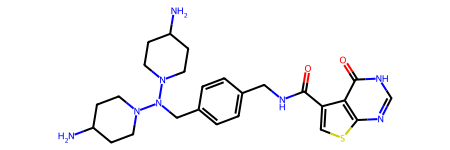

molecular weight: 480.6380000000002 | logP: 3.5184000000000015 | HBA: 7 | HBD: 2


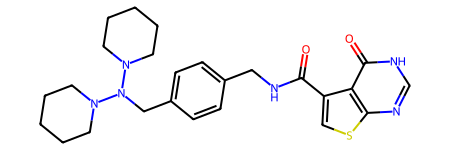

molecular weight: 484.5820000000002 | logP: 1.211 | HBA: 9 | HBD: 2


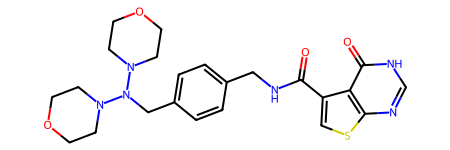

molecular weight: 370.47800000000007 | logP: 2.7564 | HBA: 5 | HBD: 2


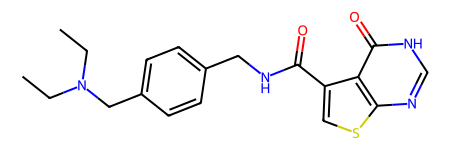

molecular weight: 424.5700000000003 | logP: 4.069200000000003 | HBA: 5 | HBD: 2


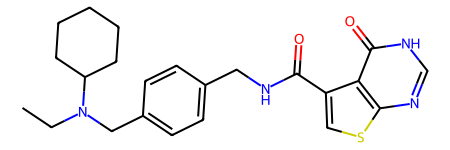

molecular weight: 432.5490000000001 | logP: 3.936700000000002 | HBA: 5 | HBD: 2


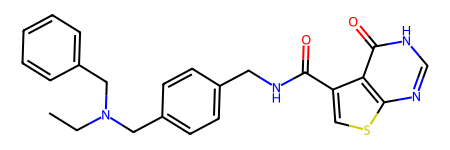

molecular weight: 404.4950000000001 | logP: 3.2044000000000015 | HBA: 5 | HBD: 3


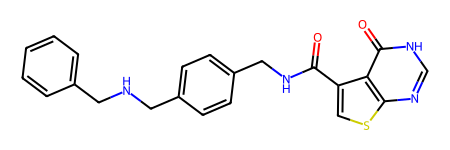

molecular weight: 426.5860000000001 | logP: 4.364700000000003 | HBA: 5 | HBD: 3


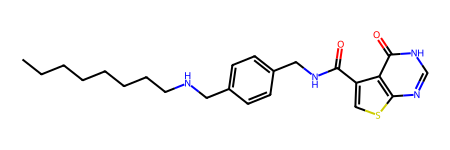

molecular weight: 396.5160000000001 | logP: 3.3369000000000018 | HBA: 5 | HBD: 3


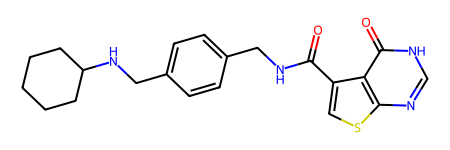

molecular weight: 488.6570000000002 | logP: 5.497100000000005 | HBA: 5 | HBD: 2


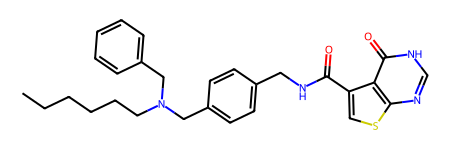

molecular weight: 454.64000000000016 | logP: 5.097000000000005 | HBA: 5 | HBD: 2


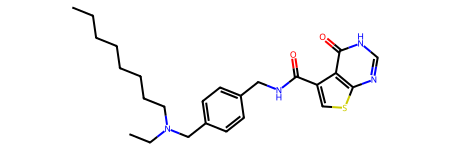

molecular weight: 516.7110000000002 | logP: 6.2773000000000065 | HBA: 5 | HBD: 2


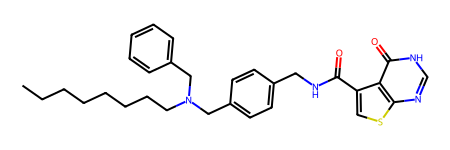

molecular weight: 370.47800000000007 | logP: 2.8043000000000005 | HBA: 5 | HBD: 3


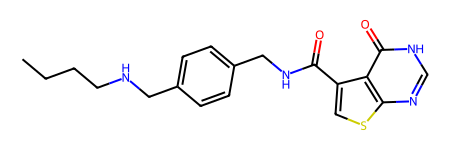

molecular weight: 384.5050000000001 | logP: 3.194400000000001 | HBA: 5 | HBD: 3


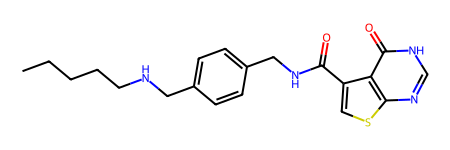

molecular weight: 454.64000000000016 | logP: 5.144900000000004 | HBA: 5 | HBD: 3


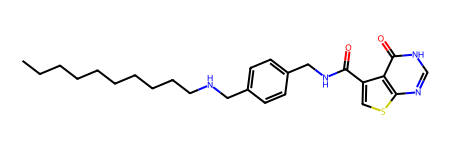

molecular weight: 417.4910000000001 | logP: 0.5177000000000002 | HBA: 8 | HBD: 5


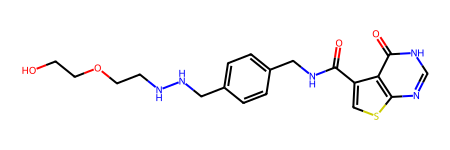

molecular weight: 445.5450000000002 | logP: 1.5619000000000003 | HBA: 8 | HBD: 4


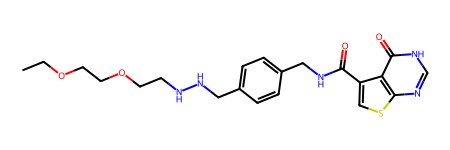

molecular weight: 482.4780000000001 | logP: 0.45379999999999954 | HBA: 10 | HBD: 6


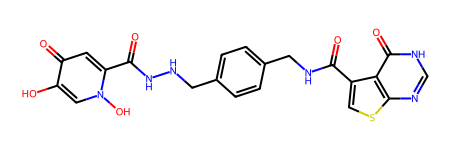

molecular weight: 595.6380000000003 | logP: 1.1304000000000007 | HBA: 11 | HBD: 7


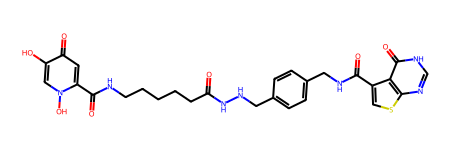

In [59]:
for row in inh.iterrows():
    mol = Chem.MolFromSmiles(row[1]["smiles"])
    print(
        f"molecular weight: {Chem.Descriptors.MolWt(mol)} | logP: {Chem.Descriptors.MolLogP(mol)} | HBA: {Chem.Descriptors.NumHAcceptors(mol)} | HBD: {Chem.Descriptors.NumHDonors(mol)}"
    )
    display(mol)

In [32]:
from screening import MolecularPropertyCalculator

In [33]:
mpc = MolecularPropertyCalculator()

In [35]:
len(known_inhibitors_mol)

19

In [54]:
results_df = pd.DataFrame(columns=["inhibitor_id", *mpc.get_result_keys()])

In [57]:
for key, value in known_inhibitors_mol.items():
    basic_filters = mpc.calculate_basic_filters(value)
    results_df = pd.concat(
        [results_df, pd.DataFrame([{**{"inhibitor_id": key}, **basic_filters}])],
        ignore_index=True,
    )

results_df

reading NP model ...


model in
[22:15:57] DEPRECATION WARNING: please use MorganGenerator
/tmp/ipykernel_334073/1966216618.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat(
reading NP model ...
model in
[22:15:57] DEPRECATION WARNING: please use MorganGenerator
reading NP model ...
model in
[22:15:58] DEPRECATION WARNING: please use MorganGenerator
reading NP model ...
model in
[22:15:58] DEPRECATION WARNING: please use MorganGenerator
reading NP model ...
model in
[22:15:58] DEPRECATION WARNING: please use MorganGenerator
reading NP model ...
model in
[22:15:58] DEPRECATION WARNING: please use MorganGenerator
reading NP model ...
model in
[22:15:59] DEPRECATION WARNING: please use MorganGenerator
reading NP model ...
model in
[22:15:59

,inhibitor_id,Lipinski_Rule_of_5,Ghose_Filter,Veber_Filter,Rule_of_3_Filter,REOS_Filter,Drug_like_Filter,QED_Filter,TPSA_Filter,SA_Score_Filter,NP_Score_Filter,ADMET_Scores_Filter,Errors
0,0,False,False,True,False,False,False,0.374388,136.61,3.339819,-1.079381,181.359743,[]
1,1,False,False,True,False,True,False,0.538384,84.57,3.051925,-1.181657,151.249145,[]
2,2,False,False,True,False,True,False,0.516054,103.03,3.147472,-1.294599,155.478274,[]
3,3,False,True,True,False,True,False,0.670319,78.09,2.467244,-1.774178,40.402747,[]
4,4,False,True,True,False,True,False,0.599323,78.09,2.589870,-1.701862,95.762497,[]
5,5,False,True,True,False,True,False,0.442149,78.09,2.422425,-1.536256,103.598697,[]
6,6,False,True,True,False,True,False,0.441459,86.88,2.320230,-1.300281,74.835097,[]
7,7,False,True,False,False,False,False,0.375531,86.88,2.464274,-1.080771,98.073647,[]
8,8,False,True,True,False,True,False,0.596398,86.88,2.460566,-1.216697,66.998897,[]
9,9,False,False,False,False,False,False,0.258308,78.09,2.512693,-1.285886,161.221697,[]


In [71]:
results_df.apply(filter_fn, axis=1)

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
dtype: bool

In [69]:
filtered_resuts_df = results_df[results_df.apply(filter_fn, axis=1)]

In [70]:
filtered_resuts_df

,inhibitor_id,Lipinski_Rule_of_5,Ghose_Filter,Veber_Filter,Rule_of_3_Filter,REOS_Filter,Drug_like_Filter,QED_Filter,TPSA_Filter,SA_Score_Filter,NP_Score_Filter,ADMET_Scores_Filter,Errors


---

In [13]:
# import requests


# def get_smiles_from_chembl(chembl_id):
#     url = f"https://www.ebi.ac.uk/chembl/api/data/molecule/{chembl_id}"
#     response = requests.get(url)
#     if response.status_code == 200:
#         data = response.json()
#         return data.get("molecule_structures", {}).get("canonical_smiles", None)
#     else:
#         print(f"Failed to retrieve data for {chembl_id}")
#         return None


# # Example usage
# chembl_ids = ["CHEMBL25", "CHEMBL26", "CHEMBL27"]  # Replace with your ChEMBL IDs
# smiles_list = []

# for chembl_id in chembl_ids:
#     smiles = get_smiles_from_chembl(chembl_id)
#     if smiles:
#         smiles_list.append(smiles)
#         print(f"{chembl_id}: {smiles}")
#     else:
#         print(f"SMILES not found for {chembl_id}")

# # If you have a DataFrame with ChEMBL IDs
# import pandas as pd

# # Example DataFrame
# data = {"chembl_id": ["CHEMBL25", "CHEMBL26", "CHEMBL27"]}
# df = pd.DataFrame(data)

# # Add a new column with SMILES strings
# df["smiles"] = df["chembl_id"].apply(get_smiles_from_chembl)
# print(df)